<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning/blob/main/HW_11_time_series_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используйте базу трафика с сайта компании. 

Напишите модель для прогнозирования трафика. 

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D, RepeatVector

from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler 

#
from tensorflow.keras.callbacks import LearningRateScheduler


import gdown

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Загружаем базу трафика с сайта компании
import gdown
gdown.download('https://storage.googleapis.com/datasets_ai/Base/11_timeseries/traff.csv', None, quiet=True)

'traff.csv'

In [ ]:
df = pd.read_csv('traff.csv',  header=None, names=['_','traffic']).drop(columns=['_'])
df.head()

,traffic
0,"22,226.00"
1,"29,593.00"
2,"31,726.00"
3,"32,684.00"
4,"31,820.00"


In [ ]:
df.traffic.describe()

count          1095
unique         1061
top       21,890.00
freq              3
Name: traffic, dtype: object

In [ ]:
df.traffic.min(), df.traffic.max()

('13,744.00', '37,665.00')

In [ ]:
def str_to_int(x):
  x = x.split(',')
  x = "".join(x)
  x = int(float(x))
  return x

In [ ]:
df.traffic = [str_to_int(x) for x in df.traffic]

In [ ]:
df.head()

,traffic
0,22226
1,29593
2,31726
3,32684
4,31820


In [ ]:
df.shape

(1095, 1)

In [ ]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

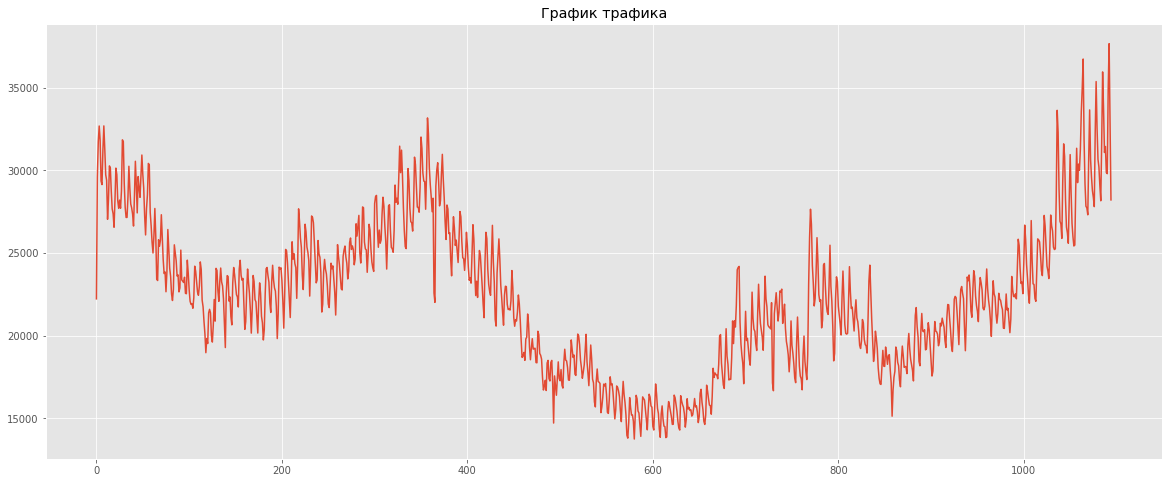

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df.index, df.traffic)
plt.title('График трафика')
plt.show()


In [ ]:
data = df.to_numpy()
data

array([[22226],
       [29593],
       [31726],
       ...,
       [37665],
       [32643],
       [28212]])

In [ ]:
data_list = data.reshape(1, -1)

In [ ]:
data_list

array([[22226, 29593, 31726, ..., 37665, 32643, 28212]])

In [ ]:
diff_traffic = np.diff(df.traffic)

In [ ]:
diff_traffic

array([ 7367,  2133,   958, ...,  2752, -5022, -4431])

In [ ]:
df.index.shape

(1095,)

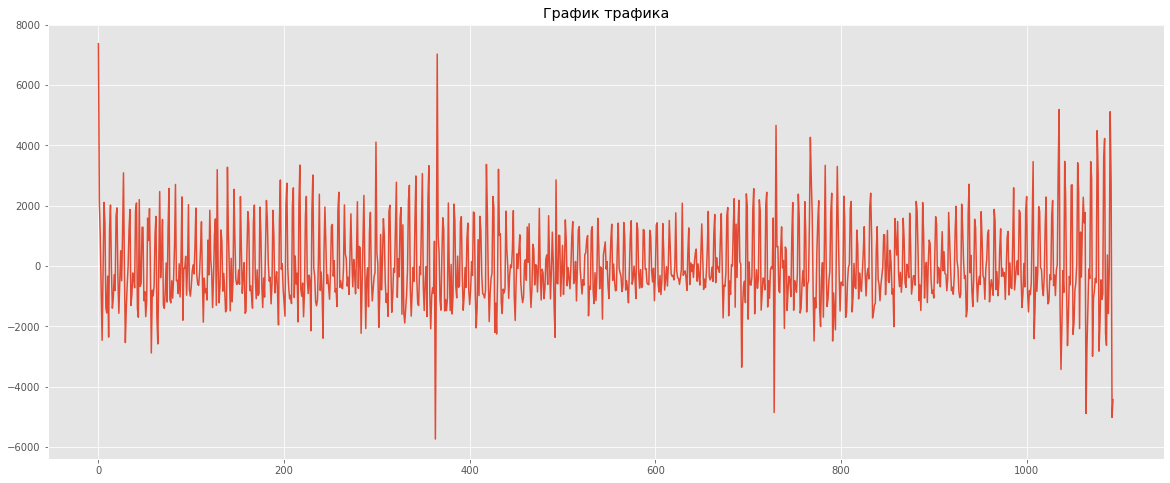

In [ ]:
plt.figure(figsize=(20, 8))
y = diff_traffic
x = range(len(y))
plt.plot(x,y)
plt.title('График трафика')
plt.show()

не думаю, что стоит дифференцировать ряд, пропали некоторые особенности

In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


In [ ]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=[0], # список каналов данных для отрисовки (по умолчанию один канал)
              chn_names=['Traffic'], 
              title=''): # список имен каналов данных
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)
    
    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()


In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 title=''):
  


    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    
    
    plt.plot(y_pred[start:start + length],
                label=f' Прогноз')
    plt.plot(y_true[start:start + length], 
                label=f' Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):
  
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)
    
    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед 
    show_predict(y_pred[1:], y_true[:-1], start, length, 
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, 
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [ ]:
# Функция обучения модели и отрисовки прогресса и оценки результатов 

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test, 
                   y_scaler, 
                   start=0, 
                   length=500, 
                   back_steps_max=30, 
                   title=''):
  
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, 
                            epochs=epochs, 
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, 
                 length=length, back_steps_max=back_steps_max, title=title)

In [ ]:
SEQ_LEN = 60                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                          # Объем батча для генератора
TEST_LEN = 300                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

# Разделение данных на тренировочный и тестовый наборы
# SEQ_LEN - для разрыва между тренировочными и тестовыми данными 
# 2 - варьируемый параметр, страховка от пересечения
xTrain,xTest = df[:TRAIN_LEN], df[TRAIN_LEN+SEQ_LEN+2:]


xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:TRAIN_LEN],(-1,1)), np.reshape(data[TRAIN_LEN+SEQ_LEN+2:],(-1,1)) 


yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)


trainDataGen = TimeseriesGenerator(xTrain, yTrain, 
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)               

testDataGen = TimeseriesGenerator(xTest, yTest,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)
print(trainDataGen[0][0].shape)

(795, 1)
(238, 1)
(795, 1)
(238, 1)
(20, 60, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку

DataGen = TimeseriesGenerator(xTest, yTest,
                               length=SEQ_LEN,
                                stride=1,
                                sampling_rate=1,
                               batch_size=len(xTest))

# Формирование тестовой выборки из генератора
xVal1, yVal1 = DataGen[0]

# Проверка формы тестовой выборки
print(f'Test x: {xVal1.shape}, y: {yVal1.shape}')

Test x: (178, 60, 1), y: (178, 1)


## Модель

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 60, 1)]      0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 60, 48)       9600        ['input_10[0][0]']               
                                                                                                  
 dropout_18 (Dropout)           (None, 60, 48)       0           ['lstm_18[0][0]']                
                                                                                                  
 lstm_19 (LSTM)                 (None, 60, 48)       18624       ['dropout_18[0][0]']             
                                                                                            

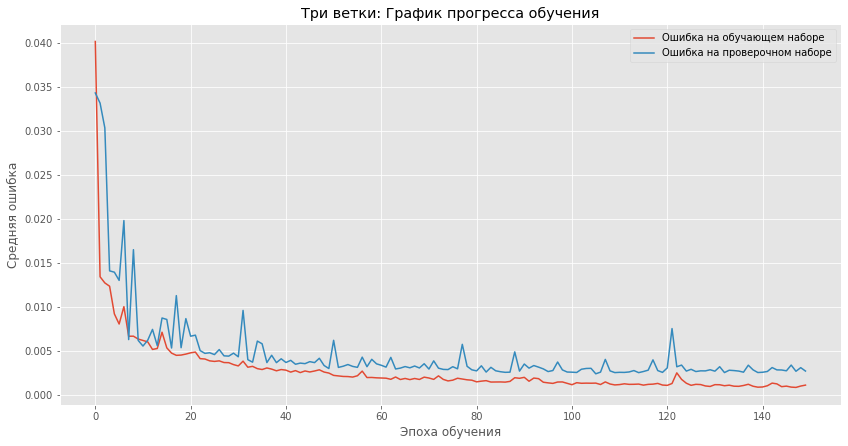

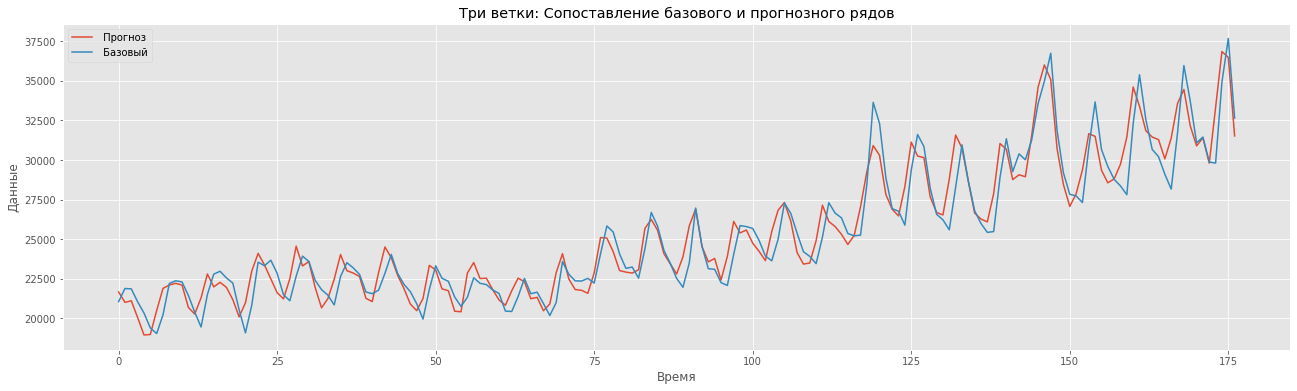

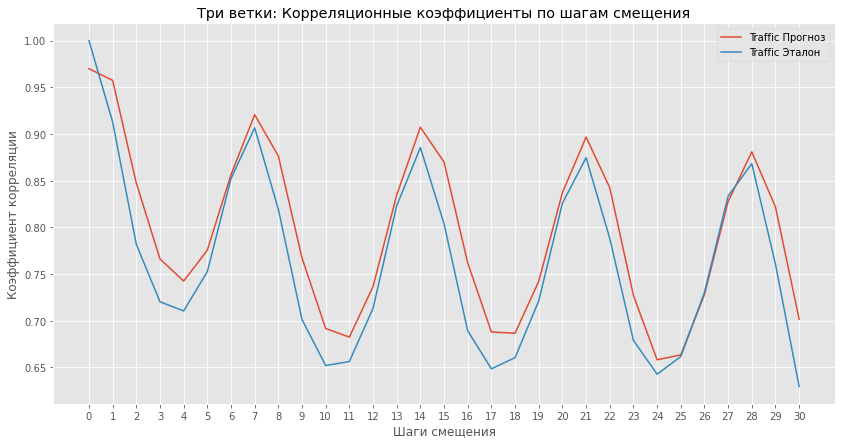

Обучение 100 эпох
Epoch 1/100
37/37 [==============================] - 4s 32ms/step - loss: 8.7611e-04 - val_loss: 0.0026
Epoch 2/100
37/37 [==============================] - 0s 11ms/step - loss: 7.9599e-04 - val_loss: 0.0026
Epoch 3/100
37/37 [==============================] - 0s 11ms/step - loss: 7.9270e-04 - val_loss: 0.0027
Epoch 4/100
37/37 [==============================] - 0s 11ms/step - loss: 7.8616e-04 - val_loss: 0.0026
Epoch 5/100
37/37 [==============================] - 0s 11ms/step - loss: 7.6733e-04 - val_loss: 0.0027
Epoch 6/100
37/37 [==============================] - 0s 11ms/step - loss: 8.0366e-04 - val_loss: 0.0026
Epoch 7/100
37/37 [==============================] - 0s 11ms/step - loss: 7.6298e-04 - val_loss: 0.0027
Epoch 8/100
37/37 [==============================] - 0s 11ms/step - loss: 7.7250e-04 - val_loss: 0.0026
Epoch 9/100
37/37 [==============================] - 0s 11ms/step - loss: 7.6935e-04 - val_loss: 0.0026
Epoch 10/100
37/37 [==========================

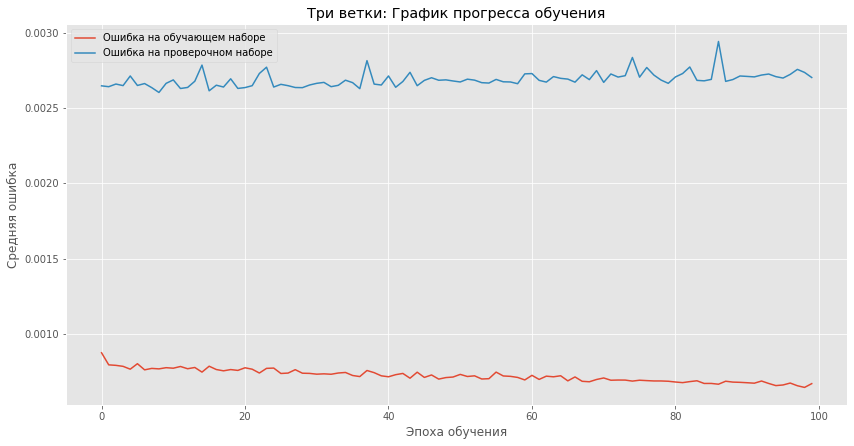

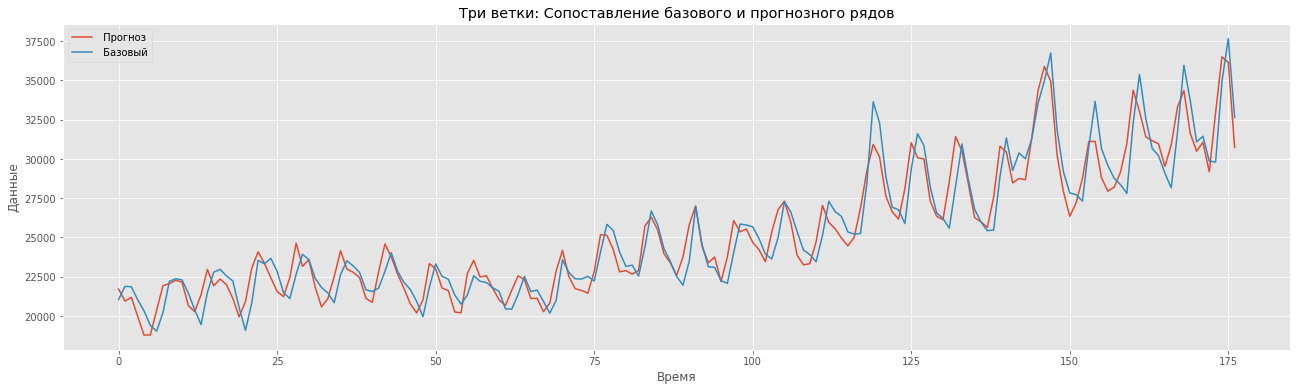

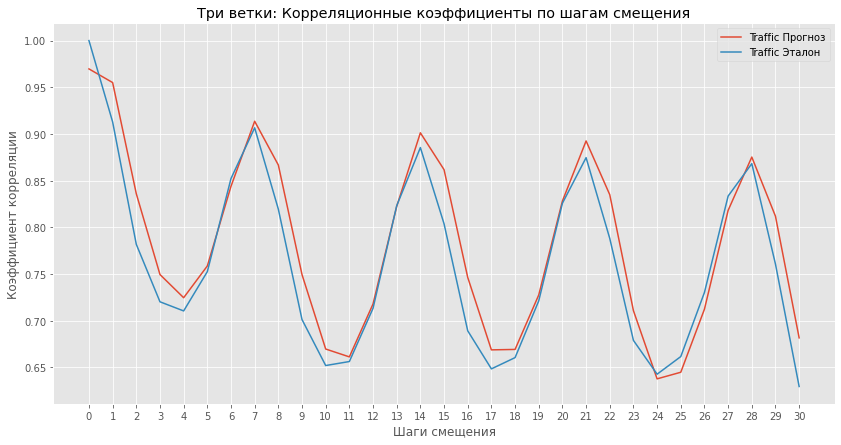

Обучение 50 эпох
Epoch 1/50
37/37 [==============================] - 4s 32ms/step - loss: 6.4142e-04 - val_loss: 0.0027
Epoch 2/50
37/37 [==============================] - 0s 11ms/step - loss: 6.4962e-04 - val_loss: 0.0027
Epoch 3/50
37/37 [==============================] - 0s 11ms/step - loss: 6.4564e-04 - val_loss: 0.0027
Epoch 4/50
37/37 [==============================] - 0s 11ms/step - loss: 6.4079e-04 - val_loss: 0.0027
Epoch 5/50
37/37 [==============================] - 0s 11ms/step - loss: 6.4946e-04 - val_loss: 0.0027
Epoch 6/50
37/37 [==============================] - 0s 11ms/step - loss: 6.3876e-04 - val_loss: 0.0027
Epoch 7/50
37/37 [==============================] - 0s 11ms/step - loss: 6.4581e-04 - val_loss: 0.0027
Epoch 8/50
37/37 [==============================] - 0s 11ms/step - loss: 6.2879e-04 - val_loss: 0.0027
Epoch 9/50
37/37 [==============================] - 0s 11ms/step - loss: 6.5122e-04 - val_loss: 0.0027
Epoch 10/50
37/37 [==============================] - 0s 

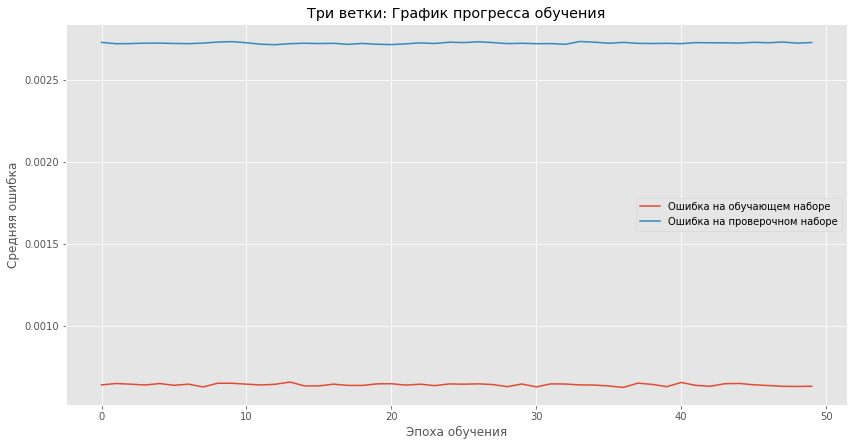

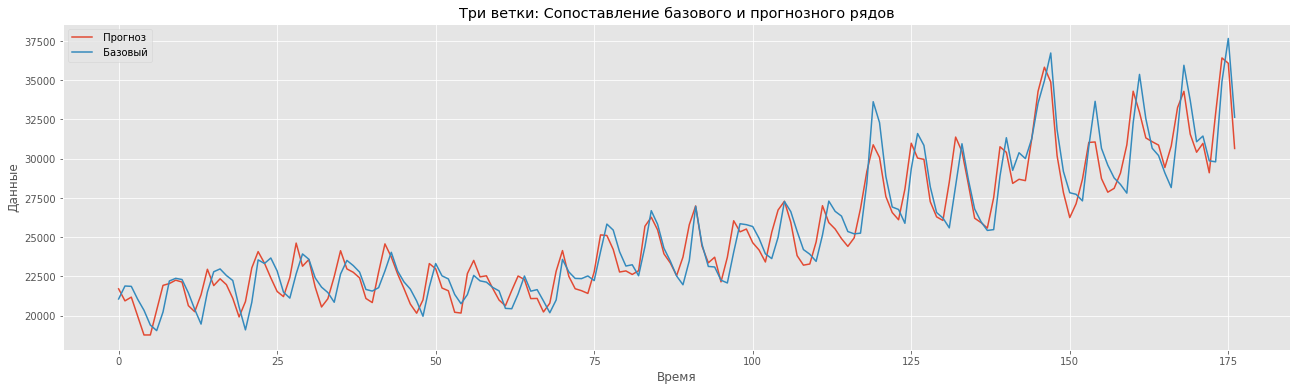

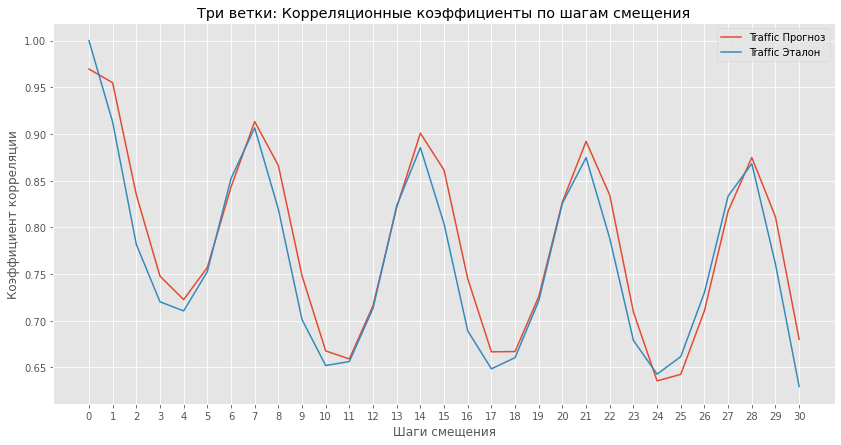

In [ ]:
MyInput = Input(shape=(SEQ_LEN,1))

lstm1 = LSTM(48, return_sequences="True")(MyInput) 
lstm1 = Dropout(0.3)(lstm1) 
lstm1 = LSTM(48, return_sequences="True")(lstm1) 
lstm1 = Dropout(0.3)(lstm1) 

conv2 = Conv1D(100, 5, activation="relu")(MyInput) 
conv2 = Conv1D(100, 5, activation="relu")(conv2) 

dense3 = Dense(10, activation="linear")(MyInput) 
dense3 = Dense(10, activation="linear")(dense3)

lstm1 = Flatten()(lstm1)
conv2 = Flatten()(conv2)
dense3 = Flatten()(dense3)

final4 = concatenate([lstm1, conv2, dense3])
final4 = Dense(10, activation="linear")(final4)
final4 = Dense(1, activation="linear")(final4)

model_complex = Model(MyInput, final4)


train_eval_net(model_complex, trainDataGen, testDataGen, [(150, Adam(lr=1e-4)),
                                                         (100, Adam(lr=1e-5)),
                                                         (50, Adam(lr=1e-6))],
               xVal1, yVal1, yScaler, title='Tри ветки')

In [ ]:
'''# Функция создания пробного генератора и вывода его результатов на экран
# На входе - имитация выборок x_train, y_train
def show_gen(x_train, y_train, length=10, batch_size=5):
    # Создание генератора TimeseriesGenerator
    gen = TimeseriesGenerator(x_train,
                              y_train,
                              length=length,
                              sampling_rate=1,
                              stride=1,
                              batch_size=batch_size
                             )
    
    # Прохождение по элементам генератора (батчам) в цикле и вывод каждого батча
    for i, g in enumerate(gen):
        print('Батч №', i)
        print('x_train:\n', g[0])
        print('y_train:\n', g[1])
        print()  


show_gen(x_data_test, x_data_test, length = SEQ_LEN,
                                  batch_size=BATCH_SIZE)  '''